In [59]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [60]:
df = pd.read_csv('mnist_test.csv')

In [61]:
df.shape

(10000, 785)

In [62]:
df.head(1)

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,1x11,1x12,1x13,1x14,1x15,1x16,1x17,1x18,1x19,1x20,1x21,1x22,1x23,1x24,1x25,1x26,1x27,1x28,2x1,2x2,2x3,2x4,2x5,2x6,2x7,2x8,2x9,2x10,2x11,...,27x17,27x18,27x19,27x20,27x21,27x22,27x23,27x24,27x25,27x26,27x27,27x28,28x1,28x2,28x3,28x4,28x5,28x6,28x7,28x8,28x9,28x10,28x11,28x12,28x13,28x14,28x15,28x16,28x17,28x18,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [63]:
anom = df[:1000].copy()
clean = df[1000:].copy()

In [64]:
for i in range(len(anom)):
    # select row from anom
    row = anom.iloc[i]
    # iterate through each element in row
    for i in range(len(row)-1):
        # add noise to element
        row[i+1] = min(255, row[i+1]+random.randint(100,200))

In [65]:
anom['label'] = 1
clean['label'] = 0

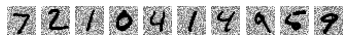

In [66]:
img = anom.iloc[:, 1:]
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(img.iloc[i,:].values.reshape(28,28), cmap = "gray_r")

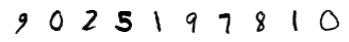

In [67]:
img2 = clean.iloc[:, 1:]
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(img2.iloc[i,:].values.reshape(28,28), cmap = "gray_r")

In [68]:
an_test = pd.concat([anom, clean])  # join
an_test.sample(frac=1)              # shuffle
an_test.to_csv('anom.csv')          # save

In [69]:
import torch.nn as nn

class AE(nn.Module):
    def __init__(self):
        
        super(AE, self).__init__()        
        self.enc = nn.Sequential(
                    nn.Linear(784, 512),
                    nn.ReLU(),
                    nn.Linear(512, 256),
                    nn.ReLU(),
                    nn.Linear(256, 128),
                    nn.ReLU(),
                    nn.Linear(128, 64),
                    nn.ReLU(),
                    nn.Linear(64, 32),
                    nn.ReLU(),
                    nn.Linear(32, 16),
                    nn.ReLU()
        )
        self.dec = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.ReLU()
        )
    def forward(self, x):
            encode = self.enc(x)
            decode = self.dec(encode)
            return decode

In [70]:
import torch
import time
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
from datetime import timedelta

In [71]:
batch_size = 32
lr = 1e-2         # learning rate
# 과적합을 방지하기 위해서 규제 항목 추가 
w_d = 1e-5        # weight decay
momentum = 0.9   
epochs = 15

In [72]:
class Loader(torch.utils.data.Dataset):
    def __init__(self):
        super(Loader, self).__init__()
        self.dataset = ''
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        row = self.dataset.iloc[idx]
        row = row.drop(labels={'label'})
        data = torch.from_numpy(np.array(row)/255).float()
        return data
    
class Train_Loader(Loader):
    def __init__(self):
        super(Train_Loader, self).__init__()
        self.dataset = pd.read_csv(
                       'mnist_train.csv',
                       index_col=False
                       )


In [73]:
train_set = Train_Loader()

train_ = torch.utils.data.DataLoader(
            train_set,
            batch_size=batch_size,
            shuffle=True,
            #num_workers=20,
            pin_memory=True,
            drop_last=True
        )

In [74]:
train_

In [75]:
metrics = defaultdict(list)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = AE()
model.to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=w_d)

In [76]:
model.train()
start = time.time()
for epoch in range(epochs):
    ep_start = time.time()
    running_loss = 0.0
    for bx, (data) in enumerate(train_):
        sample = model(data.to(device))
        loss = criterion(data.to(device), sample)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss/len(train_set)
    metrics['train_loss'].append(epoch_loss)
    ep_end = time.time()
    print('-----------------------------------------------')
    print('[EPOCH] {}/{}\n[LOSS] {}'.format(epoch+1,epochs,epoch_loss))
    print('Epoch Complete in {}'.format(timedelta(seconds=ep_end-ep_start)))
end = time.time()
print('-----------------------------------------------')
print('[System Complete: {}]'.format(timedelta(seconds=end-start)))

-----------------------------------------------
[EPOCH] 1/15
[LOSS] 0.0033628352807213865
Epoch Complete in 0:00:56.783185
-----------------------------------------------
[EPOCH] 2/15
[LOSS] 0.0032696612836172183
Epoch Complete in 0:00:56.611871
-----------------------------------------------
[EPOCH] 3/15
[LOSS] 0.003175515274827679
Epoch Complete in 0:00:56.700423
-----------------------------------------------
[EPOCH] 4/15
[LOSS] 0.0030771671233077846
Epoch Complete in 0:00:56.654788
-----------------------------------------------
[EPOCH] 5/15
[LOSS] 0.0029693941445400316
Epoch Complete in 0:00:56.375477
-----------------------------------------------
[EPOCH] 6/15
[LOSS] 0.0028628753361602624
Epoch Complete in 0:00:56.756814
-----------------------------------------------
[EPOCH] 7/15
[LOSS] 0.002775606703013182
Epoch Complete in 0:00:56.784614
-----------------------------------------------
[EPOCH] 8/15
[LOSS] 0.002713648401697477
Epoch Complete in 0:00:56.438546
-------------------

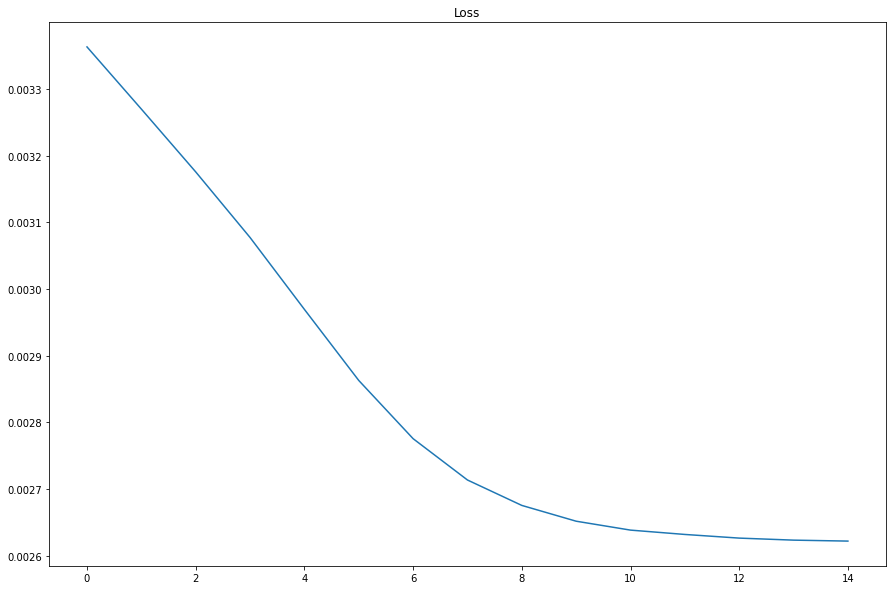

In [77]:
_, ax = plt.subplots(1,1,figsize=(15,10))
ax.set_title('Loss')
ax.plot(metrics['train_loss'])

In [78]:
model.eval()
loss_dist = []
anom = pd.read_csv('anom.csv', index_col=[0])
#for bx, data in enumerate(test_):
for i in range(len(anom)):
    data = torch.from_numpy(np.array(anom.iloc[i][1:])/255).float()
    sample = model(data.to(device))
    loss = criterion(data.to(device), sample)
    loss_dist.append(loss.item())


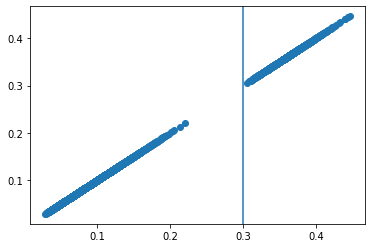

In [79]:
loss_sc = []
for i in loss_dist:
    loss_sc.append((i,i))
plt.scatter(*zip(*loss_sc))
plt.axvline(0.3, 0.0, 1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


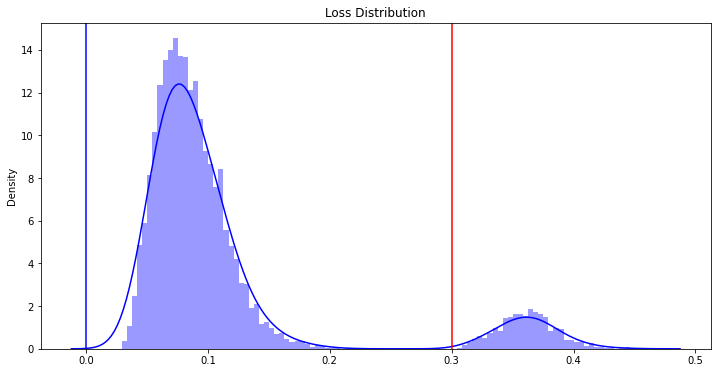

In [80]:
lower_threshold = 0.0
upper_threshold = 0.3
plt.figure(figsize=(12,6))
plt.title('Loss Distribution')
sns.distplot(loss_dist,bins=100,kde=True, color='blue')
plt.axvline(upper_threshold, 0.0, 10, color='r')
plt.axvline(lower_threshold, 0.0, 10, color='b')

In [81]:
df = pd.read_csv('anom.csv', index_col=[0])
ddf = pd.DataFrame(columns=df.columns)
tp = 0
fp = 0
tn = 0
fn = 0
total_anom = 0
for i in range(len(loss_dist)):
    total_anom += df.iloc[i]['label']
    if loss_dist[i] >= upper_threshold:
        n_df = pd.DataFrame([df.iloc[i]])
        n_df['loss'] = loss_dist[i]
        ddf = pd.concat([df,n_df], sort = True)
        if float(df.iloc[i]['label']) == 1.0:
            tp += 1
        else:
            fp += 1
    else:
        if float(df.iloc[i]['label']) == 1.0:
            fn += 1
        else:
            tn += 1
print('[TP] {}\t[FP] {}\t[MISSED] {}'.format(tp, fp, total_anom-tp))
print('[TN] {}\t[FN] {}'.format(tn, fn))


[TP] 1000	[FP] 0	[MISSED] 0
[TN] 9000	[FN] 0
